In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

import re
import os

# Structuring Dataset

In [2]:
with open("data/AQQS_allatom_optimized_geometry.lt", "r") as file:
    file_content = file.readlines()
# Create a DataFrame with each line as a separate row in a single column
monomer = pd.DataFrame(file_content, columns=['data'])
data = monomer[monomer["data"].str.contains(r"\$atom\:[A-Z]\d+\s+\$mol")].reset_index(drop=True)
data["data"] = data["data"].str.split('\s')
data["data"] = data["data"].apply(lambda x: list(filter(None, x)))
data["atom"] = data["data"].apply(lambda x: x[0].replace("$atom:", ""))
data["elements"] = data["atom"].str.replace(r"\d+", "", regex=True)
data["gromos elemts"] = data["data"].apply(lambda x: x[2].replace("@atom:", ""))
data["charge"] = data["data"].apply(lambda x: x[3]).astype(float)
data["x"] = data["data"].apply(lambda x: x[4]).astype(float)
data["y"] = data["data"].apply(lambda x: x[5]).astype(float)
data["z"] = data["data"].apply(lambda x: x[6]).astype(float)
data.drop("data", axis=1, inplace=True)

In [3]:
# Distinguishing Elements
C = data[data["elements"].isin(["C"])].reset_index(drop=True)
H = data[data["elements"].isin(["H"])].reset_index(drop=True)
F = data[data["elements"].isin(["F"])].reset_index(drop=True)
O = data[data["elements"].isin(["O"])].reset_index(drop=True)
S = data[data["elements"].isin(["S"])].reset_index(drop=True)

### ¿Hace sentido el siguiente plot? ¿es lo que se espera?, cualitativamente hablando.

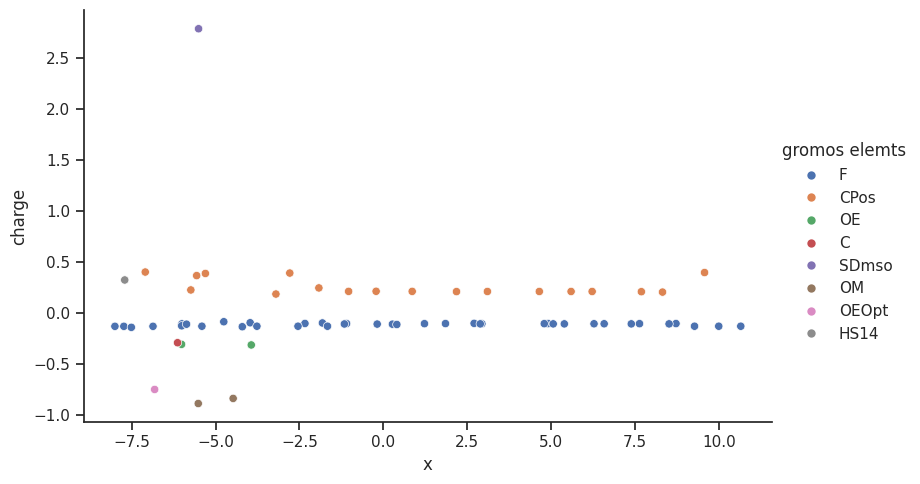

In [4]:
sns.relplot(data=data, x='x', y='charge', hue='gromos elemts', hue_order=data["gromos elemts"].unique(), aspect=1.61);

In [5]:
# Special charge
data[data["gromos elemts"].isin(["C"])]

,atom,elements,gromos elemts,charge,x,y,z
57,C19,C,C,-0.292,-6.132086,-2.404404,0.186568


# Monomer and Polymer Structure

![nafion](nafion_monomer_lbls.png "nafion")

```Python
# 128 atoms (bond: C13 = C13, C33 = C14 | removed: F3 = F3, F67 = F28)
remove /monomer1///AQQS`0/F2
remove /monomer2///AQQS`0/F67
bond /rep1///AQQS`0/C13, /rep1///AQQS`0/C33

# 254 atoms (bond: C32 = C13, C55 = C14 | removed: F41 = F2, F104 = F26)
remove /copy_rep1///AQQS`0/F104
remove /rep1///AQQS`0/F41
bond /rep2///AQQS`0/C32, /rep2///AQQS`0/C52

# 506 atoms (bond: C70 = C13, C93 = C14 | removed: F119 = F2, F182 = F26)
remove /rep2///AQQS`0/F119
remove /rep2_copy///AQQS`0/F182
bond /rep3///AQQS`0/C70, /rep3///AQQS`0/C90
#save POLYMERx8.pdb, rep3
```

In [6]:
deleted_F_list = ["F2","F67","F104","F41","F119","F182"]
unified_C_list = ["C13", "C33", "C32", "C52", "C70", "C90"]

In [7]:
def get_bonds():
    bonds = monomer[monomer["data"].str.contains(r"\$bond\:b")].reset_index(drop=True)
    bonds["data"] = bonds["data"].str.split('\s')
    bonds["data"] = bonds["data"].apply(lambda x: list(filter(None, x)))
    bonds["b"] = bonds["data"].apply(lambda x: x[0].replace("$bond:b", "")) # index
    bonds["g"] = bonds["data"].apply(lambda x: x[1].replace("@bond:g", "")) # type
    bonds["atom1"] = bonds["data"].apply(lambda x: x[2].replace("$atom:", ""))
    bonds["atom2"] = bonds["data"].apply(lambda x: x[3].replace("$atom:", ""))
    bonds.drop("data", axis=1, inplace=True)
    return bonds

In [8]:
def get_angles():
    angles = monomer[monomer["data"].str.contains(r"\$angle\:a")].reset_index(drop=True)
    angles["data"] = angles["data"].str.split('\s')
    angles["data"] = angles["data"].apply(lambda x: list(filter(None, x)))
    angles["a"] = angles["data"].apply(lambda x: x[0].replace("$angle:a", "")) # index
    angles["g"] = angles["data"].apply(lambda x: x[1].replace("@angle:g", "")) # type
    angles["atom1"] = angles["data"].apply(lambda x: x[2].replace("$atom:", ""))
    angles["atom2"] = angles["data"].apply(lambda x: x[3].replace("$atom:", ""))
    angles["atom3"] = angles["data"].apply(lambda x: x[4].replace("$atom:", ""))
    angles.drop("data", axis=1, inplace=True)
    return angles

In [9]:
def get_dihedrals():
    dihedrals = monomer[monomer["data"].str.contains(r"\$dihedral\:d")].reset_index(drop=True)
    dihedrals["data"] = dihedrals["data"].str.split('\s')
    dihedrals["data"] = dihedrals["data"].apply(lambda x: list(filter(None, x)))
    dihedrals["d"] = dihedrals["data"].apply(lambda x: x[0].replace("$dihedral:d", "")) # index
    dihedrals["g"] = dihedrals["data"].apply(lambda x: x[1].replace("@dihedral:g", "")) # type
    dihedrals["atom1"] = dihedrals["data"].apply(lambda x: x[2].replace("$atom:", ""))
    dihedrals["atom2"] = dihedrals["data"].apply(lambda x: x[3].replace("$atom:", ""))
    dihedrals["atom3"] = dihedrals["data"].apply(lambda x: x[4].replace("$atom:", ""))
    dihedrals["atom4"] = dihedrals["data"].apply(lambda x: x[5].replace("$atom:", ""))
    dihedrals.drop("data", axis=1, inplace=True)
    return dihedrals

In [10]:
C["idx"] = (C["atom"].apply(lambda x: x.replace('C',''))).astype(int)
C = C[["atom", "gromos elemts","charge","idx"]].sort_values("idx").reset_index(drop=True)
C.drop("idx", axis=1, inplace=True)

H["idx"] = (H["atom"].apply(lambda x: x.replace('H',''))).astype(int)
H = H[["atom", "gromos elemts","charge","idx"]].sort_values("idx").reset_index(drop=True)
H.drop("idx", axis=1, inplace=True)

F["idx"] = (F["atom"].apply(lambda x: x.replace('F',''))).astype(int)
F = F[["atom", "gromos elemts","charge","idx"]].sort_values("idx").reset_index(drop=True)
F.drop("idx", axis=1, inplace=True)

O["idx"] = (O["atom"].apply(lambda x: x.replace('O',''))).astype(int)
O = O[["atom", "gromos elemts","charge","idx"]].sort_values("idx").reset_index(drop=True)
O.drop("idx", axis=1, inplace=True)

S["idx"] = (S["atom"].apply(lambda x: x.replace('S',''))).astype(int)
S = S[["atom", "gromos elemts","charge","idx"]].sort_values("idx").reset_index(drop=True)
S.drop("idx", axis=1, inplace=True)

for j in range(2,9): # C19HF39O5S
    C[f"x{j}"] = [f"C{i}" for i in range(19*(j-1) + 1, 19*j + 1)]
    H[f"x{j}"] = [f"H{i}" for i in range(1*(j-1) + 1, 1*j + 1)]
    F[f"x{j}"] = [f"F{i}" for i in range(39*(j-1) + 1, 39*j + 1)]
    O[f"x{j}"] = [f"O{i}" for i in range(5*(j-1) + 1, 5*j + 1)]
    S[f"x{j}"] = [f"S{i}" for i in range(1*(j-1) + 1, 1*j + 1)]
    
polymer_data = pd.concat([C, H, F, O, S], axis=0).reset_index(drop=True)

In [11]:
non_existent_F = ["F2","F41", "F67", "F80","F104","F119","F145","F158","F182","F197","F223","F236","F260","F301"]

In [12]:
# Creating dictionaries for mapping polymer data
charges = (
    polymer_data[["atom","charge"]].set_index("atom")["charge"].to_dict() |
    polymer_data[["x2","charge"]].set_index("x2")["charge"].to_dict()     |
    polymer_data[["x3","charge"]].set_index("x3")["charge"].to_dict()     |
    polymer_data[["x4","charge"]].set_index("x4")["charge"].to_dict()     |
    polymer_data[["x5","charge"]].set_index("x5")["charge"].to_dict()     |
    polymer_data[["x6","charge"]].set_index("x6")["charge"].to_dict()     |
    polymer_data[["x7","charge"]].set_index("x7")["charge"].to_dict()     |
    polymer_data[["x8","charge"]].set_index("x8")["charge"].to_dict()     
)

gromos = (
    polymer_data[["atom","gromos elemts"]].set_index("atom")["gromos elemts"].to_dict() |
    polymer_data[["x2","gromos elemts"]].set_index("x2")["gromos elemts"].to_dict()     |
    polymer_data[["x3","gromos elemts"]].set_index("x3")["gromos elemts"].to_dict()     |
    polymer_data[["x4","gromos elemts"]].set_index("x4")["gromos elemts"].to_dict()     |
    polymer_data[["x5","gromos elemts"]].set_index("x5")["gromos elemts"].to_dict()     |
    polymer_data[["x6","gromos elemts"]].set_index("x6")["gromos elemts"].to_dict()     |
    polymer_data[["x7","gromos elemts"]].set_index("x7")["gromos elemts"].to_dict()     |
    polymer_data[["x8","gromos elemts"]].set_index("x8")["gromos elemts"].to_dict()     
)

# PDB Analysis

In [13]:
with open("data/POLYMERx8.pdb", "r") as file:
    file_content = file.readlines()
polymer = pd.DataFrame(file_content, columns=['data'])
polymer = polymer[polymer["data"].str.contains("HETATM")]
polymer["data"] = polymer["data"].str.split('\s').apply(lambda x: list(filter(None, x)))
polymer["PDB idx"] = polymer["data"].apply(lambda x: x[1])
polymer["atom"] = polymer["data"].apply(lambda x: x[2])
polymer["x"] = polymer["data"].apply(lambda x: x[5])
polymer["y"] = polymer["data"].apply(lambda x: x[6])
polymer["z"] = polymer["data"].apply(lambda x: x[7])
polymer.drop("data", axis=1, inplace=True)
polymer["charges"] = polymer["atom"].map(charges)
polymer["gromos elemts"] = polymer["atom"].map(gromos)

# Fixing Polymer Data

## Bonds

In [14]:
ένα_δεσμό = get_bonds()

δύο_δεσμούς = get_bonds()[["b","g"]]
δύο_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_δεσμούς.loc[δύο_δεσμούς.index, "b"] = δύο_δεσμούς["b"].astype(int) + len(ένα_δεσμό)

τρία_δεσμούς = get_bonds()[["b","g"]]
τρία_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_δεσμούς.loc[τρία_δεσμούς.index, "b"] = τρία_δεσμούς["b"].astype(int) + len(ένα_δεσμό)*2

τέσσερις_δεσμούς = get_bonds()[["b","g"]]
τέσσερις_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_δεσμούς.loc[τέσσερις_δεσμούς.index, "b"] = τέσσερις_δεσμούς["b"].astype(int) + len(ένα_δεσμό)*3

πέντε_δεσμούς = get_bonds()[["b","g"]]
πέντε_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_δεσμούς.loc[πέντε_δεσμούς.index, "b"] = πέντε_δεσμούς["b"].astype(int) + len(ένα_δεσμό)*4

έξι_δεσμούς = get_bonds()[["b","g"]]
έξι_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_δεσμούς.loc[έξι_δεσμούς.index, "b"] = έξι_δεσμούς["b"].astype(int) + len(ένα_δεσμό)*5

επτά_δεσμούς = get_bonds()[["b","g"]]
επτά_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_δεσμούς.loc[επτά_δεσμούς.index, "b"] = επτά_δεσμούς["b"].astype(int) + len(ένα_δεσμό)*6

οκτώ_δεσμούς = get_bonds()[["b","g"]]
οκτώ_δεσμούς["atom1"] = ένα_δεσμό["atom1"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_δεσμούς["atom2"] = ένα_δεσμό["atom2"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_δεσμούς.loc[οκτώ_δεσμούς.index, "b"] = οκτώ_δεσμούς["b"].astype(int) + len(ένα_δεσμό)*7

bonds = pd.concat([
    ένα_δεσμό,
    δύο_δεσμούς,
    τρία_δεσμούς,
    τέσσερις_δεσμούς,
    πέντε_δεσμούς,
    έξι_δεσμούς,
    επτά_δεσμούς,
    οκτώ_δεσμούς
]).reset_index(drop=True)

corrected_bonds = [
    [3,28,"C13","C33"],
    [67,28,"C32","C52"],
    [107,28,"C33","C13"],   # repeated
    [131,28,"C51","C71"],    # from C13 - C33
    [169,28,"C52","C32"],   # repeated
    [195,28,"C70","C90"],
    [235,28,"C71","C51"],   # repeated
    [259,28,"C89","C109"],
    [297,28,"C90","C71"],   # repeated
    [323,28,"C108","C128"],
    [363,28,"C109","C89"],  # repeated
    [387,28,"C127","C147"],
    [425,28,"C128","C108"], # repeated | Unificación de mierda por cierto | intentar mejorar
    [491,28,"C147","C127"],
]

bonds["b"] = bonds["b"].astype(int)

corrected_bonds = pd.DataFrame(corrected_bonds, columns=["b","g","atom1","atom2"])
modified_bonds = bonds[bonds["atom1"].isin(non_existent_F) | bonds["atom2"].isin(non_existent_F)].index
bonds.loc[modified_bonds,"g"] = corrected_bonds["g"].values
bonds.loc[modified_bonds,"atom2"] = corrected_bonds["atom2"].values

# removing repeated data
bonds.drop(bonds[bonds["b"].isin([107,169,235,297,363,425])].index, axis=0, inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds["b"] = list(range(1,len(bonds) + 1))

## Angles

In [15]:
ένα_γωνία = get_angles()

δύο_γωνίες = get_angles()[["a","g"]]
δύο_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_γωνίες.loc[δύο_γωνίες.index, "a"] = δύο_γωνίες["a"].astype(int) + len(ένα_γωνία)

τρία_γωνίες = get_angles()[["a","g"]]
τρία_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_γωνίες.loc[τρία_γωνίες.index, "a"] = τρία_γωνίες["a"].astype(int) + len(ένα_γωνία)*2

τέσσερις_γωνίες = get_angles()[["a","g"]]
τέσσερις_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_γωνίες.loc[τέσσερις_γωνίες.index, "a"] = τέσσερις_γωνίες["a"].astype(int) + len(ένα_γωνία)*3

πέντε_γωνίες = get_angles()[["a","g"]]
πέντε_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_γωνίες.loc[πέντε_γωνίες.index, "a"] = πέντε_γωνίες["a"].astype(int) + len(ένα_γωνία)*4

έξι_γωνίες = get_angles()[["a","g"]]
έξι_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_γωνίες.loc[έξι_γωνίες.index, "a"] = έξι_γωνίες["a"].astype(int) + len(ένα_γωνία)*5

επτά_γωνίες = get_angles()[["a","g"]]
επτά_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_γωνίες.loc[επτά_γωνίες.index, "a"] = επτά_γωνίες["a"].astype(int) + len(ένα_γωνία)*6

οκτώ_γωνίες = get_angles()[["a","g"]]
οκτώ_γωνίες["atom1"] = ένα_γωνία["atom1"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_γωνίες["atom2"] = ένα_γωνία["atom2"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_γωνίες["atom3"] = ένα_γωνία["atom3"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_γωνίες.loc[οκτώ_γωνίες.index, "a"] = οκτώ_γωνίες["a"].astype(int) + len(ένα_γωνία)*7

angles = pd.concat([
    ένα_γωνία,
    δύο_γωνίες,
    τρία_γωνίες,
    τέσσερις_γωνίες,
    πέντε_γωνίες,
    έξι_γωνίες,
    επτά_γωνίες,
    οκτώ_γωνίες
]).reset_index(drop=True)


removed_F = angles[
    angles["atom1"].isin(deleted_F_list) |
    angles["atom2"].isin(deleted_F_list) |
    angles["atom3"].isin(deleted_F_list)
].index

angles["a"] = angles["a"].astype(int)

# I am creating this object by comparing with the original and modified structure through PyMol
# REMARKS
# Modified C13 looks like normal C9
# Modified C33 looks like normal C7

# Modified C32 looks like normal C28 (C9)
# Modified C52 looks like normal C31 (C12)

# Modified C70 looks like normal C66 (C28, C9)
# Modified C90 looks like normal C67 (C10)
corrected_angles = [
    [2,15,"F3","C13","C33"],       # correcting F2 - C13
    [4,14,"F1","C13","C33"],       # correcting F2 - C13
    [6,15,"C33", "C13", "C12"],    # correcting F2 - C13
    [125,15,"F42","C32","C52"],    # correcting F41 - C32
    [127,14,"F40","C32","C52"],    # correcting F41 - C32
    [129,15,"C52","C32","C31"],    # correcting F41 - C32
    [204,13,"C20","C33","C13"],    # correcting F67 - C33
    [206,154,"F65","C33","C13"],   # correcting F67 - C33
    [207,14,"F66","C33","C13"],    # correcting F67 - C33
    [248,15,"F81","C51","C71"],    # correcting F80 - C51 (C51=C13, F81=F3)
    [250,14,"F79","C51","C71"],    # correcting F80 - C51 (C51=C13, F79=F1)
    [252,15,"C71","C51","C50"],    # correcting F80 - C51 (C51=C13, C12=C50)
    [325,15,"C39","C52","C32"],    # correcting F104 - C52
    [328,102,"C32","C52","F105"],  # correcting F104 - C52
    [329,154,"C32","C52","F106"],  # correcting F104 - C52
    [371,15,"F120","C70","C90"],   # correcting F119 - C70
    [373,14,"F118","C70","C90"],   # correcting F119 - C70
    [375,15,"C90","C70","C69"],    # correcting F119 - C70
    [450,13,"C58","C71","C51"],    # correcting F145 - C71 (C71=C33,C58=C20)
    [452,154,"F143","C71","C51"],  # correcting F145 - C71 (C71=C33, F143=F65)
    [453,14,"F144","C71","C51"],   # correcting F145 - C71 (C71=C33, F144=F66)
    [494,15,"F159","C89","C109"],  # correcting F158 - C89 (C89=C13, F159=F3)
    [496,14,"F157","C89","C109"],  # correcting F158 - C89 (C89=C13, F157=F1)
    [498,15,"C109","C89","C88"],   # correcting F158 - C89 (C89=C13, C88=C12)
    [571,15,"C77","C90","C70"],    # correcting F182 - C90
    [574,15,"C70","C90","F183"],   # correcting F182 - C90
    [575,8,"C70","C90","F184"],    # correcting F182 - C90
    [617,15,"F198","C108","C128"], # horrible connection | supposed to be like C32
    [619,14,"F196","C108","C128"], # correcting F197 - C108
    [621,15,"C128","C108","C107"], # correcting F197 - C108
    [696,13,"C96","C109","C89"],   # correcting F223 - C109 (C109=C33)
    [698,154,"F221","C109","C89"], # correcting F223 - C109 (C109=C33)
    [699,14,"F222","C109","C89"],  # correcting F223 - C109 (C109=C33)
    [740,15,"F237","C127","C147"], # correcting F236 - C127 (C127=C51=C13)
    [742,14,"F235","C127","C147"], # correcting F236 - C127 (C127=C51=C13)
    [744,15,"C147","C127","C126"], # correcting F236 - C127 (C127=C51=C13)
    [817,15,"C115","C128","C108"], # C128 is supposed to be like C52
    [820,102,"C108","C128","F261"],# correcting F260 - C128
    [821,154,"C108","C128","F262"],# correcting F260 - C128
    [942,13,"C134","C147","C127"], # correcting F301 - C147 (C147=C71=C33)
    [944,154,"F299","C147","C127"],# correcting F301 - C147 (C147=C71=C33)
    [945,14,"F300","C147","C127"], # correcting F301 - C147 (C147=C71=C33)
]

modified_angles = angles[
    angles["atom1"].isin(non_existent_F) |
    angles["atom3"].isin(non_existent_F)
] 
#modified_angles[modified_angles["atom2"].isin(["C128"])]

# sele /improved_polymer///AQQS`0/C90
corrected_angles = pd.DataFrame(corrected_angles,columns=["a","g","atom1","atom2","atom3"])

# Sanity check : all modified angles will be corrected?
print(len(angles.loc[modified_angles.index]) == len(corrected_angles))

angles.loc[modified_angles.index, "g"] = corrected_angles["g"].values
angles.loc[modified_angles.index, "atom1"] = corrected_angles["atom1"].values
angles.loc[modified_angles.index, "atom3"] = corrected_angles["atom3"].values

# Sanity check: all modified angles were correctly resolved?
#angles.loc[modified_angles.index].reset_index(drop=True) == corrected_angles

True


## Torsion Angle

In [16]:
ένα_συστροφή = get_dihedrals()

δύο_συστροφή = get_dihedrals()[["d","g"]]
δύο_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x2"]].set_index("atom")["x2"].to_dict())
δύο_συστροφή.loc[δύο_συστροφή.index, "d"] = δύο_συστροφή["d"].astype(int) + len(ένα_συστροφή)

τρία_συστροφή = get_dihedrals()[["d","g"]]
τρία_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x3"]].set_index("atom")["x3"].to_dict())
τρία_συστροφή.loc[τρία_συστροφή.index, "d"] = τρία_συστροφή["d"].astype(int) + len(ένα_συστροφή)*2

τέσσερις_συστροφή = get_dihedrals()[["d","g"]]
τέσσερις_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x4"]].set_index("atom")["x4"].to_dict())
τέσσερις_συστροφή.loc[τέσσερις_συστροφή.index, "d"] = τέσσερις_συστροφή["d"].astype(int) + len(ένα_συστροφή)*3

πέντε_συστροφή = get_dihedrals()[["d","g"]]
πέντε_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x5"]].set_index("atom")["x5"].to_dict())
πέντε_συστροφή.loc[πέντε_συστροφή.index, "d"] = πέντε_συστροφή["d"].astype(int) + len(ένα_συστροφή)*4

έξι_συστροφή = get_dihedrals()[["d","g"]]
έξι_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x6"]].set_index("atom")["x6"].to_dict())
έξι_συστροφή.loc[έξι_συστροφή.index, "d"] = έξι_συστροφή["d"].astype(int) + len(ένα_συστροφή)*5

επτά_συστροφή = get_dihedrals()[["d","g"]]
επτά_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x7"]].set_index("atom")["x7"].to_dict())
επτά_συστροφή.loc[επτά_συστροφή.index, "d"] = επτά_συστροφή["d"].astype(int) + len(ένα_συστροφή)*6

οκτώ_συστροφή = get_dihedrals()[["d","g"]]
οκτώ_συστροφή["atom1"] = ένα_συστροφή["atom1"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_συστροφή["atom2"] = ένα_συστροφή["atom2"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_συστροφή["atom3"] = ένα_συστροφή["atom3"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_συστροφή["atom4"] = ένα_συστροφή["atom4"].map(polymer_data[["atom","x8"]].set_index("atom")["x8"].to_dict())
οκτώ_συστροφή.loc[οκτώ_συστροφή.index, "d"] = οκτώ_συστροφή["d"].astype(int) + len(ένα_συστροφή)*7

dihedrals = pd.concat([
    ένα_συστροφή,
    δύο_συστροφή,
    τρία_συστροφή,
    τέσσερις_συστροφή,
    πέντε_συστροφή,
    έξι_συστροφή,
    επτά_συστροφή,
    οκτώ_συστροφή
]).reset_index(drop=True)

In [18]:
# sele /improved_polymer///AQQS`0/C13

# Only possible values: lj14, 46, 34
# If all atoms are C: g46 or g34 NOT lj14

modified_dihedrals =  dihedrals[
    dihedrals["atom1"].isin(non_existent_F) |
    dihedrals["atom4"].isin(non_existent_F)
]#.reset_index(drop=True)

# If there is a flourine or oxygen, I am setting lj14,
# if there are only carbons, I am comparing with similar structures to 
# determine wheter it is 46 or 34

corrected_dihedrals = [
    [10,"lj14","C33","C13","C12","F4"],
    [11,"lj14","C33","C13","C12","F5"],
    [12,34,"C33","C13","C12","C11"],
    [178,"lj14","C52","C32","C31","F43"],
    [179,"lj14","C52","C32","C31","F44"],
    [180,34,"C52","C32","C31","C30"],
    [273,34,"C21", "C20", "C33", "C13"],
    [286,"lj14","F78","C20","C33","C13"],
    [291,"lj14","O6","C20","C33","C13"],
    [346,"lj14","C71","C51","C50","F82"],
    [347,"lj14","C71","C51","C50","F83"],
    [348,34,"C71","C51","C50","C49"],
    [439,46,"C40","C39","C52","C32"],
    [452,"lj14","F117","C39","C52","C32"],
    [457,"lj14","O11","C39","C52","C32"],
    [514,"lj14","C90","C70","C69","F121"],
    [515,"lj14","C90","C70","C69","F122"],
    [516,34,"C90","C70","C69","C68"],
    [609,34,"C59","C58","C71","C51"],
    [622,"lj14","F156","C58","C71","C51"],
    [627,"lj14","O16","C58","C71","C51"],
    [682,"lj14","C109","C89","C88","F160"], 
    [683,"lj14","C109","C89","C88","F161"], 
    [684,34,"C109","C89","C88","C87"],
    [775,34,"C78","C77","C90","C70"],
    [788,"lj14","F195","C77","C90","C70"],
    [793,"lj14","O21","C77","C90","C70"],
    [850,"lj14","C128","C108","C107","F199"],
    [851,"lj14","C128","C108","C107","F200"],
    [852,46,"C128","C108","C107","C106"],
    [945,34,"C97","C96","C109","C89"],
    [958,"lj14","F234","C96","C109","C89"],
    [963,"lj14","O26","C96","C109","C89"],
    [1018,"lj14","C147","C127","C126","F238"],
    [1019,"lj14","C147","C127","C126","F239"],
    [1020,34,"C147","C127","C126","C125"],
    [1111,"lj14","C116","C115","C128","C108"],
    [1124,46,"F273","C115","C128","C108"],
    [1129,"lj14","O31","C115","C128","C108"],
    [1281,"lj14","C135","C134","C147","C127"],
    [1294,34,"F312","C134","C147","C127"],
    [1299,"lj14","O36","C134","C147","C127"],
]


corrected_dihedrals = pd.DataFrame(corrected_dihedrals,columns=["d","g","atom1","atom2","atom3","atom4"])

# Sanity check : all modified dihedrals will be corrected?
print(len(dihedrals.loc[modified_dihedrals.index]) == len(corrected_dihedrals))

dihedrals.loc[modified_dihedrals.index, "g"] = corrected_dihedrals["g"].values
dihedrals.loc[modified_dihedrals.index, "atom1"] = corrected_dihedrals["atom1"].values
dihedrals.loc[modified_dihedrals.index, "atom4"] = corrected_dihedrals["atom4"].values

dihedrals["d"] = dihedrals["d"].astype(int)

# Sanity check: all modified angles were correctly resolved?
#dihedrals.loc[modified_dihedrals.index].reset_index(drop=True) == corrected_dihedrals

True


## Fixing Flourine naming

In [ ]:
# renombrar por rangos segun el flourino que toque, para los 4 datasets

## Writing File for Moltemplate

[Python write](https://www.w3schools.com/python/python_file_write.asp)

In [31]:
f = open("POLYMERx8.lt", "w")
f.write('AQQS inherits GROMOS_54A7_ATB {\n')
f.write('\twrite("Data Atoms"){\n')
for i in range(len(polymer)):
    f.write(
        f'\t$atom:{polymer["atom"][i]}\t$mol:... @atom:{polymer["gromos elemts"][i]}\t'+
        f'\t{polymer["charges"][i]}\t{polymer["x"][i]}\t{polymer["y"][i]}\t{polymer["z"][i]}\n'
    )
f.write('\t}\n')
f.write('}')
f.close()